In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
c1=pd.read_csv("Data/Train/First_Health_Camp_Attended.csv")
c2=pd.read_csv("Data/Train/Second_Health_Camp_Attended.csv")
c3=pd.read_csv("Data/Train/Third_Health_Camp_Attended.csv")
c3=c3[c3.Number_of_stall_visited>0]
for camp in [c1,c2,c3]:
    camp["Outcome"]=1 

In [3]:
camp_cat=pd.read_csv("Data/Train/Health_Camp_Detail.csv")
camp_cat.Category1="camp_"+camp_cat.Category1
camp_cat.Category2="camp_"+camp_cat.Category2
#camp_cat.Category3="camp_"+camp_cat.Category3.astype(str)
camp_cat=camp_cat.join(pd.get_dummies(camp_cat.Category1))
camp_cat=camp_cat.join(pd.get_dummies(camp_cat.Category2))
#camp_cat=camp_cat.join(pd.get_dummies(camp_cat.Category3))
camp_cat=camp_cat.drop(["Category1","Category2","Category3"],axis=1)
camp_cat.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,camp_First,camp_Second,camp_Third,camp_A,camp_B,camp_C,camp_D,camp_E,camp_F,camp_G
0,6560,16-Aug-03,20-Aug-03,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6530,16-Aug-03,28-Oct-03,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6544,03-Nov-03,15-Nov-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6585,22-Nov-03,05-Dec-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6561,30-Nov-03,18-Dec-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


add/remove income,city, Employer

In [4]:
profile=pd.read_csv("Data/Train/Patient_Profile.csv")
profile=profile[[0,5,6,7,8,9,10]]
profile=profile.replace("None",np.nan)
profile.Income=profile.Income.fillna(profile.Income.astype(float).mean()).astype(int)
profile.Education_Score=profile.Education_Score.fillna(profile.Education_Score.astype(float).mean()).astype(float)
profile.Age=profile.Age.fillna(profile.Age.astype(float).mode()[0]).astype(int)#changed from mode
profile.City_Type=profile.City_Type.fillna(profile.City_Type.mode()[0])
profile.Employer_Category=profile.Employer_Category.fillna(profile.Employer_Category.mode()[0])
#profile=profile.join(pd.get_dummies(profile.Income).astype(int))
profile=profile.join(pd.get_dummies(profile.City_Type).astype(int))
profile=profile.join(pd.get_dummies(profile.Employer_Category).astype(int))
profile=profile.drop(["City_Type","Employer_Category",],axis=1)
profile.head()

,Patient_ID,Income,Education_Score,Age,First_Interaction,A,B,C,D,E,...,Food,Health,Manufacturing,Others,Real Estate,Retail,Software Industry,Technology,Telecom,Transport
0,516956,1,90.000000,39,18-Jun-03,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,507733,1,78.231288,40,20-Jul-03,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,508307,3,87.000000,46,02-Nov-02,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,512612,1,75.000000,47,02-Nov-02,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,521075,3,78.231288,80,24-Nov-02,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


no of camps attended by patient from c1,c2, c3

In [5]:
patdict={}
for i,row in profile.iterrows():
    patdict[int(row.Patient_ID)]=0

In [6]:
for i, camp in enumerate([c1,c2,c3]):
    for j,row in camp.iterrows():
        patdict[int(row.Patient_ID)]+=1
print patdict

{524288: 0, 524289: 0, 524290: 0, 524291: 2, 524292: 0, 524293: 0, 524294: 0, 524295: 4, 524296: 0, 524297: 0, 524298: 3, 524300: 0, 524301: 1, 524302: 0, 524303: 1, 524304: 0, 524305: 0, 524306: 0, 524307: 0, 524308: 0, 524309: 2, 524310: 0, 524311: 0, 524313: 0, 524314: 0, 524315: 2, 524316: 0, 524317: 0, 524318: 1, 524319: 0, 524320: 0, 524321: 2, 524322: 0, 524323: 2, 524324: 0, 524325: 0, 524326: 1, 524327: 0, 524328: 0, 524330: 0, 524331: 0, 524333: 0, 524334: 5, 524336: 0, 524337: 1, 524338: 0, 524339: 0, 524340: 6, 524342: 0, 524343: 0, 524344: 0, 524346: 0, 524347: 1, 524348: 1, 524349: 0, 524350: 0, 524351: 0, 524352: 3, 524353: 3, 524354: 5, 524355: 0, 524356: 1, 524358: 1, 524360: 1, 524361: 1, 524362: 0, 524363: 0, 524364: 1, 524366: 0, 524367: 0, 524368: 2, 524369: 1, 524370: 0, 524372: 0, 524373: 0, 524374: 1, 524375: 0, 524376: 1, 524377: 0, 524378: 1, 524379: 1, 524380: 0, 524382: 0, 524383: 1, 524385: 0, 524386: 0, 524387: 0, 524388: 1, 524389: 0, 524390: 0, 524391: 2

In [7]:
train=pd.read_csv("Data/Train/Train.csv")
train = train.merge(profile,on=['Patient_ID'], how='left')
train = train.merge(camp_cat,on='Health_Camp_ID',how='left')
arr=['Registration_Date','Camp_Start_Date','First_Interaction','Camp_End_Date']#removed campenddate
for i, row in train.iterrows():
    if row.Registration_Date is np.nan:
        train.set_value(i, "Registration_Date", row["First_Interaction"])
for elem in arr:
    train[elem] = pd.to_datetime(train[elem] ,format = '%d-%b-%y')
train["Duration"]=train.Camp_End_Date-train.Camp_Start_Date
train.Duration=train.Duration.astype('str')
train.Duration=train.Duration.str.split().str.get(0).astype(int)
train["Reg_Dur"]=train.Registration_Date-train.Camp_Start_Date
train.Reg_Dur=train.Reg_Dur.astype('str')
train.Reg_Dur=train.Reg_Dur.str.split().str.get(0).astype(int)
train["Int_Dur"]=train.Registration_Date-train.First_Interaction
train.Int_Dur=train.Int_Dur.astype('str')
train.Int_Dur=train.Int_Dur.str.split().str.get(0).astype(int)
train = train.merge(pd.concat([c1,c2,c3])[['Patient_ID','Health_Camp_ID','Outcome']], on=['Patient_ID','Health_Camp_ID'], how='left')
train.Outcome=train.Outcome.fillna(0).astype(int)
train=train.drop(arr,axis=1)
train.head()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,...,camp_B,camp_C,camp_D,camp_E,camp_F,camp_G,Duration,Reg_Dur,Int_Dur,Outcome
0,489652,6578,4,0,0,0,2,1,78.231288,41,...,0.0,0.0,0.0,0.0,0.0,1.0,59,25,278,1
1,507246,6578,45,5,0,0,7,1,75.000000,40,...,0.0,0.0,0.0,0.0,0.0,1.0,59,2,344,0
2,523729,6534,0,0,0,0,0,1,78.231288,41,...,0.0,0.0,0.0,0.0,0.0,0.0,751,194,676,1
3,524931,6535,0,0,0,0,0,1,78.231288,41,...,0.0,0.0,0.0,1.0,0.0,0.0,17,6,0,0
4,521364,6529,15,1,0,0,7,1,70.000000,40,...,0.0,0.0,0.0,0.0,0.0,0.0,4,-30,970,1


In [8]:
train.columns

Index([u'Patient_ID', u'Health_Camp_ID', u'Var1', u'Var2', u'Var3', u'Var4',
       u'Var5', u'Income', u'Education_Score', u'Age', u'A', u'B', u'C', u'D',
       u'E', u'F', u'G', u'H', u'I', u'BFSI', u'Broadcasting', u'Consulting',
       u'Education', u'Food', u'Health', u'Manufacturing', u'Others',
       u'Real Estate', u'Retail', u'Software Industry', u'Technology',
       u'Telecom', u'Transport', u'camp_First', u'camp_Second', u'camp_Third',
       u'camp_A', u'camp_B', u'camp_C', u'camp_D', u'camp_E', u'camp_F',
       u'camp_G', u'Duration', u'Reg_Dur', u'Int_Dur', u'Outcome'],
      dtype='object')

In [9]:
test=pd.read_csv("Data/Test/Test_D7W1juQ.csv")
test = test.merge(profile,on=['Patient_ID'], how='left')
test = test.merge(camp_cat,on='Health_Camp_ID',how='left')
arr=['Registration_Date','Camp_Start_Date','First_Interaction','Camp_End_Date']
for elem in arr:
    test[elem] = pd.to_datetime(test[elem] ,format = '%d-%b-%y')
    #test[elem+"_Day"]=pd.DatetimeIndex(test[elem]).day
    #test[elem+"_Month"]=pd.DatetimeIndex(test[elem]).month
    #test[elem+"_Year"]=pd.DatetimeIndex(test[elem]).year
    #test=test.drop(elem,axis=1)
test["Duration"]=test.Camp_End_Date-test.Camp_Start_Date
test.Duration=test.Duration.astype('str')
test.Duration=test.Duration.str.split().str.get(0).astype(int)
test["Reg_Dur"]=test.Registration_Date-test.Camp_Start_Date
test.Reg_Dur=test.Reg_Dur.astype('str')
test.Reg_Dur=test.Reg_Dur.str.split().str.get(0).astype(int)
test["Int_Dur"]=test.Registration_Date-test.First_Interaction
test.Int_Dur=test.Int_Dur.astype('str')
test.Int_Dur=test.Int_Dur.str.split().str.get(0).astype(int)
test=test.drop(arr,axis=1)
test.head()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,...,camp_A,camp_B,camp_C,camp_D,camp_E,camp_F,camp_G,Duration,Reg_Dur,Int_Dur
0,505701,6548,1,0,0,0,2,0,78.231288,44,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,66,-23,1201
1,500633,6584,0,0,0,0,0,1,67.000000,41,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,-63,538
2,506945,6582,0,0,0,0,0,1,78.231288,41,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,580,126,113
3,497447,6551,0,0,0,0,0,0,78.231288,47,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,-78,2
4,496446,6533,0,0,0,0,0,1,78.231288,41,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,-1,0


In [10]:
params={"learning_rate":0.01,"n_estimators":1500,"max_depth":5,"subsample":0.8,"colsample_bytree":0.8,"objective": 'binary:logistic',"nthread":4,"seed":27}

In [11]:
clf=xgb.XGBClassifier()
clf.set_params(**params)
clf=clf.fit(train[train.columns[2:train.shape[1]-1]],train.Outcome)
#clf=RandomForestClassifier()
#clf.fit(train[train.columns[2:train.shape[1]-1]],train.Outcome)

In [12]:
preds=clf.predict(test[test.columns[2:]])
print clf.predict_proba(test[test.columns[2:]])

[[ 0.70026672  0.29973331]
 [ 0.64182693  0.35817307]
 [ 0.81764913  0.18235089]
 ..., 
 [ 0.81995225  0.18004777]
 [ 0.71136969  0.28863031]
 [ 0.41818684  0.58181316]]


In [13]:
res=pd.read_csv("Data/sample_submission_cvwryvM.csv")
res.Patient_ID=test.Patient_ID
res.Health_Camp_ID=test.Health_Camp_ID
res.Outcome=clf.predict_proba(test[test.columns[2:]])[:,1]
res.to_csv("op.csv",index=False)
res.head()

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.299733
1,500633,6584,0.358173
2,506945,6582,0.182351
3,497447,6551,0.906723
4,496446,6533,0.051077


             precision    recall  f1-score   support

          0       0.85      0.92      0.88     18027
          1       0.72      0.57      0.64      6815

avg / total       0.81      0.82      0.81     24842



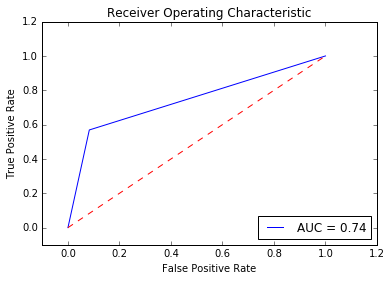

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[2:train.shape[1]-1]],train.Outcome, test_size=0.33, random_state=42)
clf=xgb.XGBClassifier()
clf.set_params(**params)
clf=clf.fit(X_train,y_train)
preds=clf.predict(X_test)
print classification_report(y_test, preds)
fpr,tpr,t=roc_curve(y_test,preds)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()